# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definition
PAST_HISTORY = 12*6 # 6 hours used to predict next values in future
FUTURE_TARGET = 15 # number of 5 min to predict  : 12 + 3
STEP = 1
BATCH_SIZE = 32

TRAIN_SPLIT_RATIO = 0.99

path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_feat_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

In [2]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [3]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        plt.savefig(os.path.join(saveFolder, f"output_{title}.jpg")) 
    plt.show()

## Load raw features

In [4]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_69728/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1710.244864,1709.520092,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1710.244864,1709.520092,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1710.244864,1709.520092,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1710.244864,1709.520092,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1710.244864,1709.520092,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,1686180300000,1830.63,1830.83,1829.89,1830.41,406.3064,2023-06-07 23:25:00,1839.040000,1841.440000,1832.730,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
45498,1686180600000,1830.41,1833.00,1830.25,1833.00,500.6436,2023-06-07 23:30:00,1839.092500,1841.440000,1832.730,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
45499,1686180900000,1833.00,1833.00,1831.00,1831.74,625.5965,2023-06-07 23:35:00,1839.202500,1841.440000,1832.730,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
45500,1686181200000,1831.75,1832.33,1830.86,1832.33,367.2071,2023-06-07 23:40:00,1839.202500,1841.440000,1831.345,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


### drop nan

In [5]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_BTC            1
vwap_z_score_ETH            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
min_low_h_BTC              13
rsi_h_BTC                  13
max_high_h_ETH             13
min_low_h_ETH              13
rsi_h_ETH                  13
max_high_h_BTC             13
chop_h_BTC                 14
chop_h_ETH                 14
ichi_cloud_a_ETH           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_BTC           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
dxy                       264
rsi_d_ETH                 335
min_low_d_BTC             335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
max_high_d_BTC            335
chop_d_ETH                335
chop_d_BTC                335
ichi_kijun_day_ETH        623
ichi_cloud_a_day_ETH      623
ichi_kijun_day_BTC        623
ichi_cloud_a_day_BTC      623
fvx                       732
spx                     

#### Cheat Backward Filling

In [6]:
df_feat = df_feat_raw.copy()

In [7]:
df_feat = df_feat.bfill(axis ='rows')

In [8]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1710.244864,1709.520092,1194.710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1710.244864,1709.520092,1194.710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1710.244864,1709.520092,1194.710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1710.244864,1709.520092,1194.710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1710.244864,1709.520092,1194.710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,1686180300000,1830.63,1830.83,1829.89,1830.41,406.3064,2023-06-07 23:25:00,1839.040000,1841.440000,1832.730,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
45498,1686180600000,1830.41,1833.00,1830.25,1833.00,500.6436,2023-06-07 23:30:00,1839.092500,1841.440000,1832.730,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
45499,1686180900000,1833.00,1833.00,1831.00,1831.74,625.5965,2023-06-07 23:35:00,1839.202500,1841.440000,1832.730,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
45500,1686181200000,1831.75,1832.33,1830.86,1832.33,367.2071,2023-06-07 23:40:00,1839.202500,1841.440000,1831.345,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


In [9]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       2817
delta_event_real    2817
delta_event_pred    2817
Previous_num        2817
Actual_num          2817
Event               2817
Date                2817
Previous            2817
Consensus           2817
Actual              2817
Country             2817
Time (ET)           2817
keep                2817
date                2817
dtype: int64

on 45502 samples


In [10]:
nb_missing

Consensus_num       2817
delta_event_real    2817
delta_event_pred    2817
Previous_num        2817
Actual_num          2817
Event               2817
Date                2817
Previous            2817
Consensus           2817
Actual              2817
Country             2817
Time (ET)           2817
keep                2817
date                2817
dtype: int64

In [11]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

In [12]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       2817
delta_event_real    2817
delta_event_pred    2817
Previous_num        2817
Actual_num          2817
Event               2817
Date                2817
Previous            2817
Consensus           2817
Actual              2817
Country             2817
Time (ET)           2817
keep                2817
date                2817
dtype: int64

on 45502 samples


In [13]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1710.244864,1709.520092,1194.710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1710.244864,1709.520092,1194.710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1710.244864,1709.520092,1194.710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1710.244864,1709.520092,1194.710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1710.244864,1709.520092,1194.710,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,1686180300000,1830.63,1830.83,1829.89,1830.41,406.3064,2023-06-07 23:25:00,1839.040000,1841.440000,1832.730,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
45498,1686180600000,1830.41,1833.00,1830.25,1833.00,500.6436,2023-06-07 23:30:00,1839.092500,1841.440000,1832.730,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
45499,1686180900000,1833.00,1833.00,1831.00,1831.74,625.5965,2023-06-07 23:35:00,1839.202500,1841.440000,1832.730,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
45500,1686181200000,1831.75,1832.33,1830.86,1832.33,367.2071,2023-06-07 23:40:00,1839.202500,1841.440000,1831.345,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


## Features Selection

### Proportional to the Price

In [14]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [15]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [16]:
df_feat[list_col_ETH]

,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,...,vwap_m_ETH,vwap_3m_ETH,vwap_6m_ETH,vwap_y_ETH,vwap_all_ETH,vwap_z_score_ETH,nupl_ETH,supply_ETH,act_addr_ETH,market_dom_ETH
0,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1710.244864,1709.520092,1194.710,1194.710,...,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,-0.634018,0.000187,1.205585e+08,279900.0,17.854085
1,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1710.244864,1709.520092,1194.710,1194.710,...,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018,-0.000353,1.205585e+08,279900.0,17.854085
2,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1710.244864,1709.520092,1194.710,1194.710,...,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604,-0.000920,1.205585e+08,279900.0,17.854085
3,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1710.244864,1709.520092,1194.710,1194.710,...,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,0.521593,0.000338,1.205585e+08,279900.0,17.854085
4,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1710.244864,1709.520092,1194.710,1194.710,...,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,0.626856,0.000371,1.205585e+08,279900.0,17.854085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,1830.63,1830.83,1829.89,1830.41,406.3064,2023-06-07 23:25:00,1839.040000,1841.440000,1832.730,1828.465,...,1851.148378,1877.574232,1782.735372,1835.449635,1706.139613,0.647757,0.067892,1.199801e+08,434840.0,19.590338
45498,1830.41,1833.00,1830.25,1833.00,500.6436,2023-06-07 23:30:00,1839.092500,1841.440000,1832.730,1829.040,...,1851.156173,1877.570078,1782.739436,1835.439009,1706.140443,0.661258,0.069209,1.199801e+08,434840.0,19.590338
45499,1833.00,1833.00,1831.00,1831.74,625.5965,2023-06-07 23:35:00,1839.202500,1841.440000,1832.730,1829.040,...,1851.157312,1877.560301,1782.742572,1835.433103,1706.141478,0.654689,0.068568,1.199801e+08,434840.0,19.590338
45500,1831.75,1832.33,1830.86,1832.33,367.2071,2023-06-07 23:40:00,1839.202500,1841.440000,1831.345,1829.040,...,1851.158170,1877.541690,1782.744630,1835.426890,1706.142085,0.657765,0.068867,1.199801e+08,434840.0,19.590338


In [17]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [18]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [19]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [20]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [21]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

### Not proportional to the Price 

In [22]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'dxy',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'spx',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [23]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    'dxy',
    'spx',
    'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    'month_cos',
    'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [24]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +    
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  104


In [25]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [26]:
df_feat.shape[0]

45502

In [27]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

45047

In [28]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,train
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1710.244864,1709.520092,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1710.244864,1709.520092,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1710.244864,1709.520092,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1710.244864,1709.520092,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1710.244864,1709.520092,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,1686180300000,1830.63,1830.83,1829.89,1830.41,406.3064,2023-06-07 23:25:00,1839.040000,1841.440000,1832.730,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
45498,1686180600000,1830.41,1833.00,1830.25,1833.00,500.6436,2023-06-07 23:30:00,1839.092500,1841.440000,1832.730,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
45499,1686180900000,1833.00,1833.00,1831.00,1831.74,625.5965,2023-06-07 23:35:00,1839.202500,1841.440000,1832.730,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
45500,1686181200000,1831.75,1832.33,1830.86,1832.33,367.2071,2023-06-07 23:40:00,1839.202500,1841.440000,1831.345,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False


In [29]:
df_feat[df_feat["train"] == True]

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,train
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1710.244864,1709.520092,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1710.244864,1709.520092,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1710.244864,1709.520092,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1710.244864,1709.520092,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1710.244864,1709.520092,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45043,1686044100000,1814.73,1816.36,1814.67,1814.93,752.1101,2023-06-06 09:35:00,1815.227500,1814.815000,1814.815,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
45044,1686044400000,1814.94,1816.65,1814.93,1816.64,487.3107,2023-06-06 09:40:00,1815.322500,1814.815000,1814.815,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
45045,1686044700000,1816.64,1817.04,1815.84,1815.86,547.8999,2023-06-06 09:45:00,1815.330000,1814.815000,1814.815,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True
45046,1686045000000,1815.87,1816.82,1815.86,1816.57,413.0919,2023-06-06 09:50:00,1815.310000,1814.815000,1814.815,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,True


In [30]:
df_feat[df_feat["train"] == False]

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,train
45048,1686045600000,1817.01,1818.01,1817.00,1818.00,595.3198,2023-06-06 10:00:00,1814.7300,1814.815,1816.835,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
45049,1686045900000,1818.01,1819.29,1817.16,1817.61,530.2490,2023-06-06 10:05:00,1814.6200,1814.815,1816.930,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
45050,1686046200000,1817.61,1818.31,1817.61,1818.19,271.2170,2023-06-06 10:10:00,1814.6200,1814.815,1816.975,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
45051,1686046500000,1818.20,1819.27,1818.19,1819.22,485.7060,2023-06-06 10:15:00,1814.6200,1815.015,1816.975,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
45052,1686046800000,1819.22,1819.54,1818.52,1818.75,747.2107,2023-06-06 10:20:00,1814.6200,1815.145,1817.280,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,1686180300000,1830.63,1830.83,1829.89,1830.41,406.3064,2023-06-07 23:25:00,1839.0400,1841.440,1832.730,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
45498,1686180600000,1830.41,1833.00,1830.25,1833.00,500.6436,2023-06-07 23:30:00,1839.0925,1841.440,1832.730,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
45499,1686180900000,1833.00,1833.00,1831.00,1831.74,625.5965,2023-06-07 23:35:00,1839.2025,1841.440,1832.730,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
45500,1686181200000,1831.75,1832.33,1830.86,1832.33,367.2071,2023-06-07 23:40:00,1839.2025,1841.440,1831.345,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False


In [31]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [32]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [33]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
    ) 
    for col in list_col_select ]

In [34]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(44961, 72, 104) (44961, 15)
(367, 72, 104) (367, 15)


In [35]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [36]:
seq_y

array([1.00060587, 1.00017074, 1.0002093 , 1.00013219, 1.00021481,
       1.00051223, 1.00052325, 0.99998898, 1.00078763, 1.00089778,
       0.99953183, 0.99964199, 1.00058384, 1.00015422, 1.00054528])

In [37]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00024793, 1.00031956, 1.00092562, ..., 0.99985124, 0.99996143,
        1.00090358],
       [1.00007161, 1.00067752, 1.00024236, ..., 0.99971357, 1.00065548,
        1.00022584],
       [1.00060587, 1.00017074, 1.0002093 , ..., 1.00058384, 1.00015422,
        1.00054528]])

In [38]:
seq_y

array([1.00060587, 1.00017074, 1.0002093 , 1.00013219, 1.00021481,
       1.00051223, 1.00052325, 0.99998898, 1.00078763, 1.00089778,
       0.99953183, 0.99964199, 1.00058384, 1.00015422, 1.00054528])

In [39]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00024793, 1.00031956, 1.00092562, ..., 0.99985124, 0.99996143,
        1.00090358],
       [1.00007161, 1.00067752, 1.00024236, ..., 0.99971357, 1.00065548,
        1.00022584],
       [1.00060587, 1.00017074, 1.0002093 , ..., 1.00058384, 1.00015422,
        1.00054528]])

In [40]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [41]:
X_train.shape

(44961, 72, 104)

In [42]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(44961, 72, 104) (44961, 15)
(367, 72, 104) (367, 15)


## Standardization

In [43]:
scaler = StandardScaler()
X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

In [44]:
#scaler_y = StandardScaler()
#y_train_sca = scaler_y.fit_transform(y_train.reshape(-1,y_train.shape[-1])).reshape(y_train.shape)
#y_test_sca = scaler_y.transform(y_test.reshape(-1,y_test.shape[-1])).reshape(y_test.shape)

scaler_y = StandardScaler()
y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

In [45]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00024793, 1.00031956, 1.00092562, ..., 0.99985124, 0.99996143,
        1.00090358],
       [1.00007161, 1.00067752, 1.00024236, ..., 0.99971357, 1.00065548,
        1.00022584],
       [1.00060587, 1.00017074, 1.0002093 , ..., 1.00058384, 1.00015422,
        1.00054528]])

In [46]:
np.mean(y_train_sca)

3.0856149171233366e-14

In [47]:
np.std(y_train_sca)

1.0

In [48]:
np.mean(y_test_sca)

-0.06240572309410813

In [49]:
np.std(y_test_sca)

0.8305580417719937

### Check unscaling

In [50]:
df_feat[list_col_select].head(10)

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_day_ETH,ichi_cloud_b_day_ETH,...,hour_sin,weekday_cos,weekday_sin,day_in_month_cos,day_in_month_sin,month_cos,month_sin,day_off,event_pred,event_real
0,1196.32,1196.13,1196.32,1195.65,1710.244864,1709.520092,1194.71,1194.71,1714.082477,1701.466915,...,0.0,0.62349,-0.781831,0.97953,0.201299,0.866025,0.5,0.0,0.0,0.0
1,1195.38,1196.31,1196.69,1194.90,1710.244864,1709.520092,1194.71,1194.71,1714.082477,1701.466915,...,0.0,0.62349,-0.781831,0.97953,0.201299,0.866025,0.5,0.0,0.0,0.0
2,1194.55,1195.38,1195.81,1194.55,1710.244864,1709.520092,1194.71,1194.71,1714.082477,1701.466915,...,0.0,0.62349,-0.781831,0.97953,0.201299,0.866025,0.5,0.0,0.0,0.0
3,1195.98,1194.55,1195.98,1194.31,1710.244864,1709.520092,1194.71,1194.71,1714.082477,1701.466915,...,0.0,0.62349,-0.781831,0.97953,0.201299,0.866025,0.5,0.0,0.0,0.0
4,1196.06,1195.98,1196.37,1195.97,1710.244864,1709.520092,1194.71,1194.71,1714.082477,1701.466915,...,0.0,0.62349,-0.781831,0.97953,0.201299,0.866025,0.5,0.0,0.0,0.0
5,1196.61,1196.06,1196.70,1196.06,1710.244864,1709.520092,1194.71,1194.71,1714.082477,1701.466915,...,0.0,0.62349,-0.781831,0.97953,0.201299,0.866025,0.5,0.0,0.0,0.0
6,1194.36,1196.62,1196.62,1193.72,1710.244864,1709.520092,1194.71,1194.71,1714.082477,1701.466915,...,0.0,0.62349,-0.781831,0.97953,0.201299,0.866025,0.5,0.0,0.0,0.0
7,1194.22,1194.37,1194.43,1192.72,1710.244864,1709.520092,1194.71,1194.71,1714.082477,1701.466915,...,0.0,0.62349,-0.781831,0.97953,0.201299,0.866025,0.5,0.0,0.0,0.0
8,1193.64,1194.22,1194.22,1193.02,1710.244864,1709.520092,1194.71,1194.71,1714.082477,1701.466915,...,0.0,0.62349,-0.781831,0.97953,0.201299,0.866025,0.5,0.0,0.0,0.0
9,1194.64,1193.64,1195.06,1193.63,1710.244864,1709.520092,1194.71,1194.71,1714.082477,1701.466915,...,0.0,0.62349,-0.781831,0.97953,0.201299,0.866025,0.5,0.0,0.0,0.0


In [51]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [52]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [53]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [54]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [55]:
X_train_sca.shape

(44961, 72, 104)

In [56]:
X_train_sca[:,-1,:].shape

(44961, 104)

In [57]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.08374508],
       [-0.03563395],
       [-0.18854061],
       ...,
       [ 0.0363946 ],
       [-0.00289648],
       [ 0.11615343]])

In [58]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(44961, 105)

In [59]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [60]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

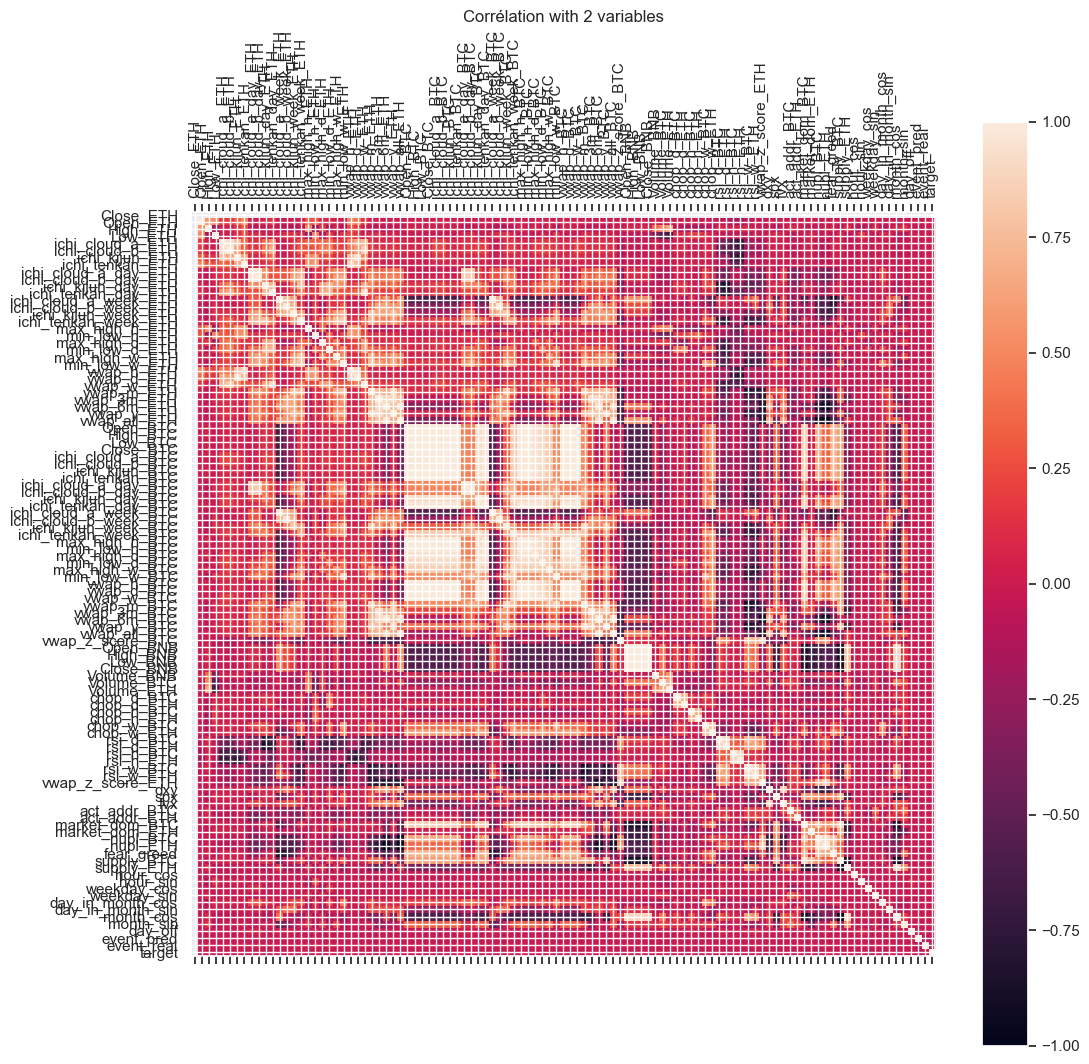

In [61]:

nb_plot = len(list_col_select)
# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
    columns=list_col_select[:nb_plot] + ['target'])

# Calculer la matrice de corrélation
corr_matrix = df.corr()

# Afficher la matrice de corrélation
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Corrélation with 2 variables')
fig.colorbar(im)
plt.show()


In [62]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00024793, 1.00031956, 1.00092562, ..., 0.99985124, 0.99996143,
        1.00090358],
       [1.00007161, 1.00067752, 1.00024236, ..., 0.99971357, 1.00065548,
        1.00022584],
       [1.00060587, 1.00017074, 1.0002093 , ..., 1.00058384, 1.00015422,
        1.00054528]])

In [63]:
y_train_sca

array([[ 0.08374508,  0.06695632, -0.10279673, ..., -0.04310335,
         0.01472461, -0.05056502],
       [-0.03563395, -0.20530887, -0.05614411, ..., -0.08784162,
        -0.1531012 , -0.28548493],
       [-0.18854061, -0.03936462, -0.14565251, ..., -0.13632901,
        -0.26872271, -0.33212251],
       ...,
       [ 0.0363946 ,  0.052355  ,  0.18740448, ..., -0.05200142,
        -0.02744697,  0.18249359],
       [-0.00289648,  0.13211953,  0.03515349, ..., -0.08267867,
         0.12720986,  0.03147123],
       [ 0.11615343,  0.01919433,  0.02778564, ...,  0.11124411,
         0.01551234,  0.10265279]])

## Autoencoder

In [64]:
X_train.shape

(44961, 72, 104)

### Model creation

### Training

Training: units 128 - enc_dim 32 - drop 0.05 ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 104)]       0         
                                                                 
 lstm (LSTM)                 (None, None, 128)         119296    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 dense (Dense)               (None, None, 32)          4128      
                                                                 
Total params: 123,424
Trainable params: 123,424
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape         

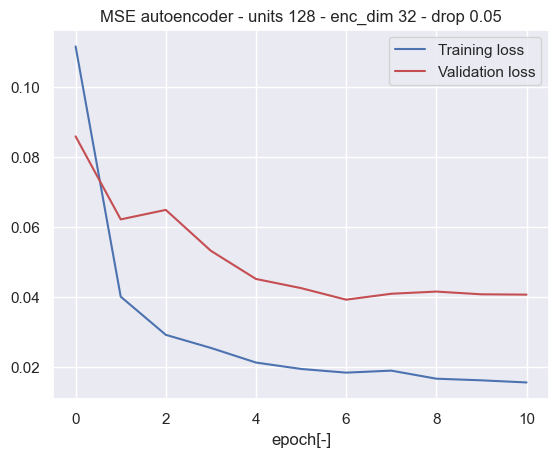

INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e32_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder_u128_e32_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e32_d0.05/assets


INFO:tensorflow:Assets written to: data/mdl_encoder_u128_e32_d0.05/assets


In [70]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
epochs = 15 #100 #150 #6 #300
patience = 4 #20 #40 #3 #100
for n_unit_enc in [128]: #[104]: #
    for encoding_dim in [32]:
        for dropout_autoenc in [0.05]: #[0.25]:
            # check already done ? 
            #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
            path_jpg = os.path.join(path_data, 
                f"output_MSE autoencoder - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}.jpg")
            if os.path.exists(path_jpg):
                print(f"BE CAREFUL ! : {path_jpg} exists => no training done...")
                continue
            print(f"Training: units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc} ...")
            # Init
            tf.keras.backend.clear_session()
            tf.random.set_seed(0)
            # Input dimension
            input_dim = X_train.shape[-1]
            # Reduced encoded input dimension
            # 64/8/0.5
            # Définir l'encodeur
            encoder_inputs = keras.Input(shape=(None, input_dim))
            encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
            #encoder = layers.LSTM(64, return_sequences=True)(encoder)
            #encoder = layers.LSTM(16, return_sequences=True)(encoder)
            encoder = layers.Dropout(dropout_autoenc)(encoder)
            encoder_outputs = layers.Dense(encoding_dim)(encoder)
            encoder_model = keras.Model(encoder_inputs, encoder_outputs)
            print(encoder_model.summary())
            # Définir le décodeur
            decoder_inputs = keras.Input(shape=(None, encoding_dim))
            #decoder = layers.LSTM(16, return_sequences=True)(decoder_inputs)
            #decoder = layers.LSTM(64, return_sequences=True)(decoder)
            decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
            decoder = layers.Dropout(dropout_autoenc)(decoder)
            decoder_outputs = layers.Dense(input_dim)(decoder)
            decoder_model = keras.Model(decoder_inputs, decoder_outputs)
            print(decoder_model.summary())
            # Define complete autoencoder 
            autoencoder_inputs = keras.Input(shape=(None, input_dim))
            encoded = encoder_model(autoencoder_inputs)
            decoded = decoder_model(encoded)
            autoencoder = keras.Model(autoencoder_inputs, decoded)
            # Compile : autoencoder
            autoencoder.compile(optimizer="adam", loss="mse")
            # earlystop 
            es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                            monitor='val_loss', mode='auto', restore_best_weights=True)
            # Train
            if patience == 0:
                autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                verbose=1)
            else:
                autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                    verbose=1, callbacks=[es])

            plot_train_history(
                autoenc_step_history,f"MSE autoencoder - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}",
                saveFolder="data")
            autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
            encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")


### Save model

In [ ]:
# TODO select best model


In [137]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [71]:
autoencoder.save(path_mdl_autoencoder)
encoder_model.save(path_mdl_encoder)


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_autoencoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


INFO:tensorflow:Assets written to: data/mdl_encoder/assets


In [139]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

1405/1405 [==============================] - 33s 23ms/step


(44940, 72, 104)

### Results

In [140]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

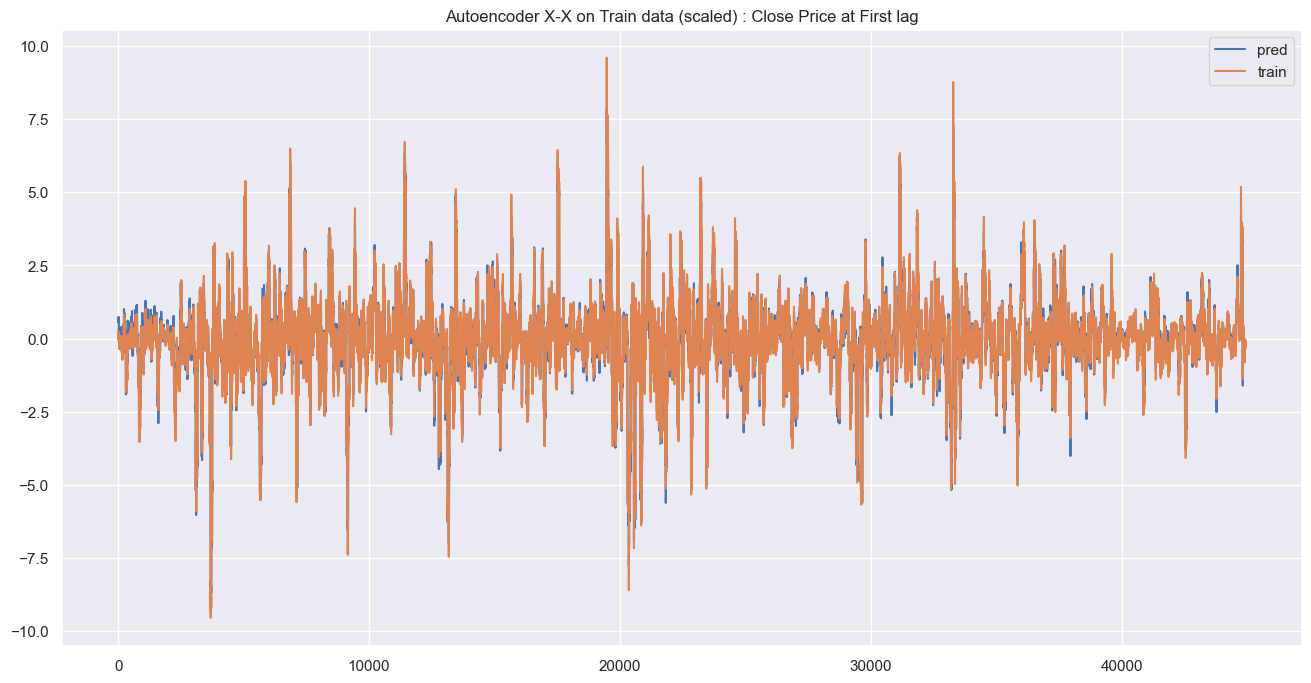

In [141]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

In [142]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(44940,)
(44940,)
[1196.32 1195.38 1194.55 ... 1810.76 1809.15 1810.91]
[1196.32 1195.38 1194.55]


In [143]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([1.0009843 , 1.0006553 , 1.0005587 , ..., 0.9987708 , 0.99865204,
       0.9992096 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 1810.76 1809.15 1810.91]
[1201.8032679  1202.23295178 1202.7286166  ... 1811.71732055 1809.49129872
 1809.93278523]


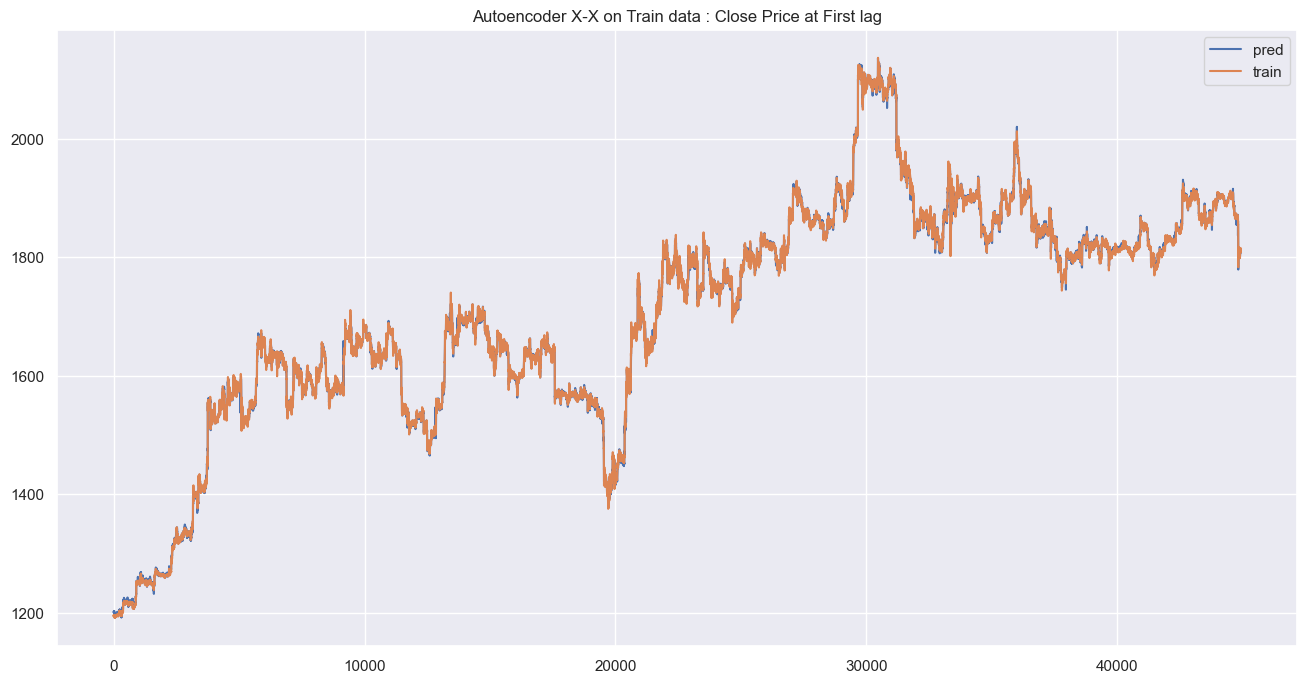

In [144]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### on Test data

In [145]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

12/12 [==============================] - 1s 37ms/step


(367, 72, 104)

In [146]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-06-06 08:10:00'

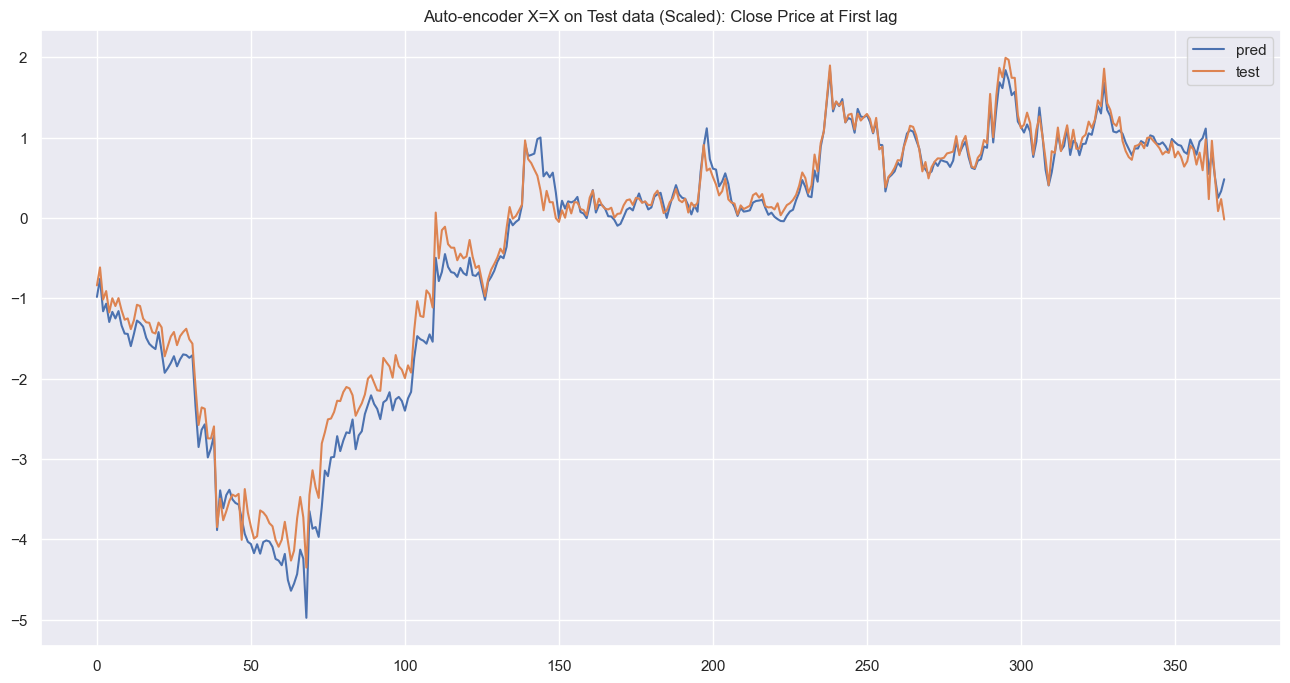

In [147]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [148]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1814.31 1814.87 1815.   1815.45 1815.58 1816.68 1815.89 1815.96 1815.82]
X test pred :  [1811.83451997 1812.43620564 1812.47403833 1812.72634426 1813.51509234
 1813.74814924 1813.21188991 1813.16584761 1812.51599835]


[1814.31 1814.87 1815.   1815.45 1815.58 1816.68 1815.89 1815.96 1815.82
 1815.97 1816.51 1816.53 1815.56 1817.01 1817.21 1814.73 1814.93 1816.64
 1815.86 1816.57 1817.   1818.   1817.61 1818.19 1819.22 1818.75 1819.06
 1819.3  1819.2  1820.17 1820.86 1819.19 1818.42 1817.78 1818.41 1817.17
 1816.86 1816.   1815.79 1815.26 1814.4  1812.68 1811.88 1811.88 1813.32
 1813.21 1813.38 1803.45 1815.44 1810.32 1807.68 1805.53 1803.29 1809.78
 1809.16 1808.05 1805.54 1806.27 1803.37 1800.99 1803.1  1806.04 1808.21
 1804.97 1805.28 1813.44 1818.52 1815.5  1817.44 1829.66 1833.97 1829.34
 1826.02 1833.11 1831.72 1836.5  1834.53 1835.42 1833.77 1836.26 1838.49
 1838.75 1841.12 1838.2  1836.28 1836.76 1836.99 1838.   1839.84 1841.12
 1842.13 1840.16 1842.22 1848.2  1846.55 1845.46 1844.   1847.21 1845.48
 1844.46 1844.73 1847.74 1847.01 1855.73 1863.66 1860.38 1859.41 1865.73
 1864.87 1861.95 1884.27 1876.86 1880.02 1877.13 1874.8  1874.83 1875.11
 1874.72 1874.93 1875.76 1875.84 1876.33 1876.8  18

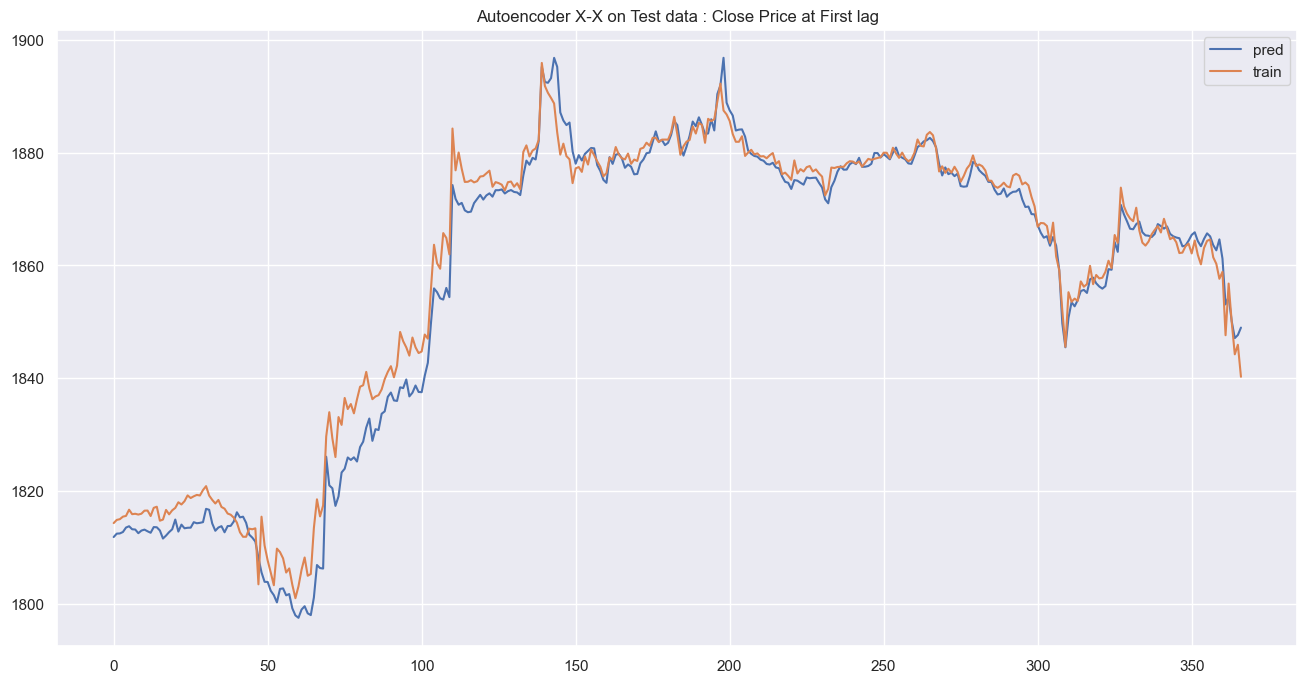

In [149]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [150]:
encoder_model.layers[3].get_weights()

[array([[ 0.40870023, -0.2516265 , -0.14572455, ...,  0.236198  ,
         -0.3051064 , -0.26059526],
        [ 0.62094444,  0.79991263,  0.2857594 , ...,  0.46706071,
         -0.20739734, -0.5374018 ],
        [ 0.47274566,  0.3369039 , -0.30471706, ..., -0.16512653,
          0.2943746 ,  0.05308647],
        ...,
        [-0.11438132, -0.01732333, -0.3082254 , ...,  0.03564474,
          0.03194961, -0.03419707],
        [-0.5547949 , -0.3137018 ,  0.15421738, ...,  0.39956114,
         -0.56820554, -0.06683543],
        [ 0.5765759 , -0.28213125, -0.79553765, ...,  0.8535231 ,
         -0.27595568,  0.08765439]], dtype=float32),
 array([-0.05061506, -0.03527927, -0.00455517,  0.05674574, -0.00748159,
         0.00986128, -0.06107264, -0.15598586,  0.02384137,  0.04494962,
         0.09330909,  0.16564754,  0.08650444, -0.03901683,  0.03286835,
        -0.01231265], dtype=float32)]

## Prediction Models

### LSTM all features

In [161]:
X_train_sca.shape

(31794, 72, 15)

In [162]:
X_train_sca.shape[-1]

15

In [163]:
X_train_sca.shape[-2:]

(72, 15)

In [173]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 50
patience = 20
dropout_rate = 0.4
n_units = 64
tf.keras.backend.clear_session()
tf.random.set_seed(0)
# optimizer def 
#optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
#                      nesterov=nesterov)
optim = tf.optimizers.Adam()

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                verbose=1, patience=patience,
                                restore_best_weights=True)
# create model
multi_step_model_1 = tf.keras.models.Sequential()
#multi_step_model_1.add(tf.keras.layers.LSTM(n_units[0], 
#                    return_sequences=True,
#                    input_shape=X_train_sca.shape[-2:],
#                    dropout=dropout_rate))
multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                    return_sequences=False,
                    input_shape=X_train_sca.shape[-2:],
                    dropout=dropout_rate))
#multi_step_model_1.add(tf.keras.layers.Dropout(dropout_rate))
multi_step_model_1.add(tf.keras.layers.LayerNormalization())
multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
# compile
multi_step_model_1.compile(optimizer=optim, loss='mse')
# fitting
'''multi_step_history = multi_step_model.fit(X_train_sca, 
                                        epochs=EPOCHS,
                                        steps_per_epoch=EVALUATION_INTERVAL,
                                        validation_data=val_data_multi,
                                        validation_steps=1,
                                        callbacks=[es],
                                        verbose=0)'''

multi_step_history_1 = multi_step_model_1.fit(
    X_train_sca, y_train_sca, epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])
# eval
mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
mse_curr_1

Epoch 1/50
994/994 [==============================] - 33s 31ms/step - loss: 1.0301 - val_loss: 1.0026
Epoch 2/50
994/994 [==============================] - 30s 30ms/step - loss: 1.0018 - val_loss: 0.9946
Epoch 3/50
994/994 [==============================] - 30s 31ms/step - loss: 1.0024 - val_loss: 0.9945
Epoch 4/50
994/994 [==============================] - 31s 31ms/step - loss: 1.0011 - val_loss: 1.0163
Epoch 5/50
994/994 [==============================] - 30s 30ms/step - loss: 0.9990 - val_loss: 0.9918
Epoch 6/50
994/994 [==============================] - 30s 30ms/step - loss: 0.9984 - val_loss: 0.9901
Epoch 7/50
994/994 [==============================] - 30s 30ms/step - loss: 0.9938 - val_loss: 0.9849
Epoch 8/50
994/994 [==============================] - 30s 30ms/step - loss: 0.9900 - val_loss: 0.9947
Epoch 9/50
994/994 [==============================] - 30s 30ms/step - loss: 0.9851 - val_loss: 0.9905
Epoch 10/50
994/994 [==============================] - 30s 30ms/step - loss: 0.981

0.9848664402961731

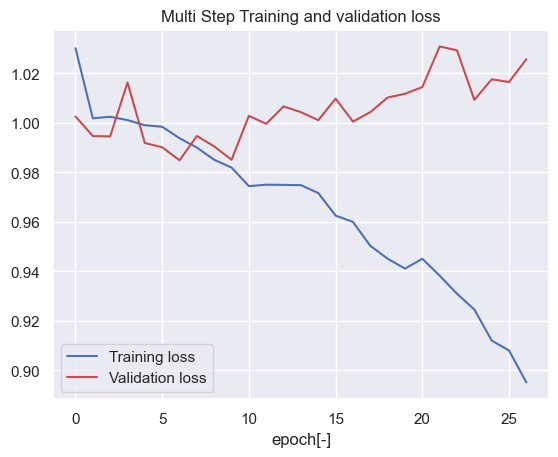

In [174]:
plot_train_history(multi_step_history_1,
                       'Multi Step Training and validation loss', "data")

#### Save

In [84]:
multi_step_model_1.save(path_mdl_predict_lstm)

INFO:tensorflow:Assets written to: data/mdl_predict_lstm/assets


INFO:tensorflow:Assets written to: data/mdl_predict_lstm/assets


#### Results

In [97]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]

9/9 [==============================] - 0s 22ms/step


In [87]:
y_train_pred_raw_1.shape

(34944, 15)

In [88]:
y_train_raw.shape

(34944, 15)

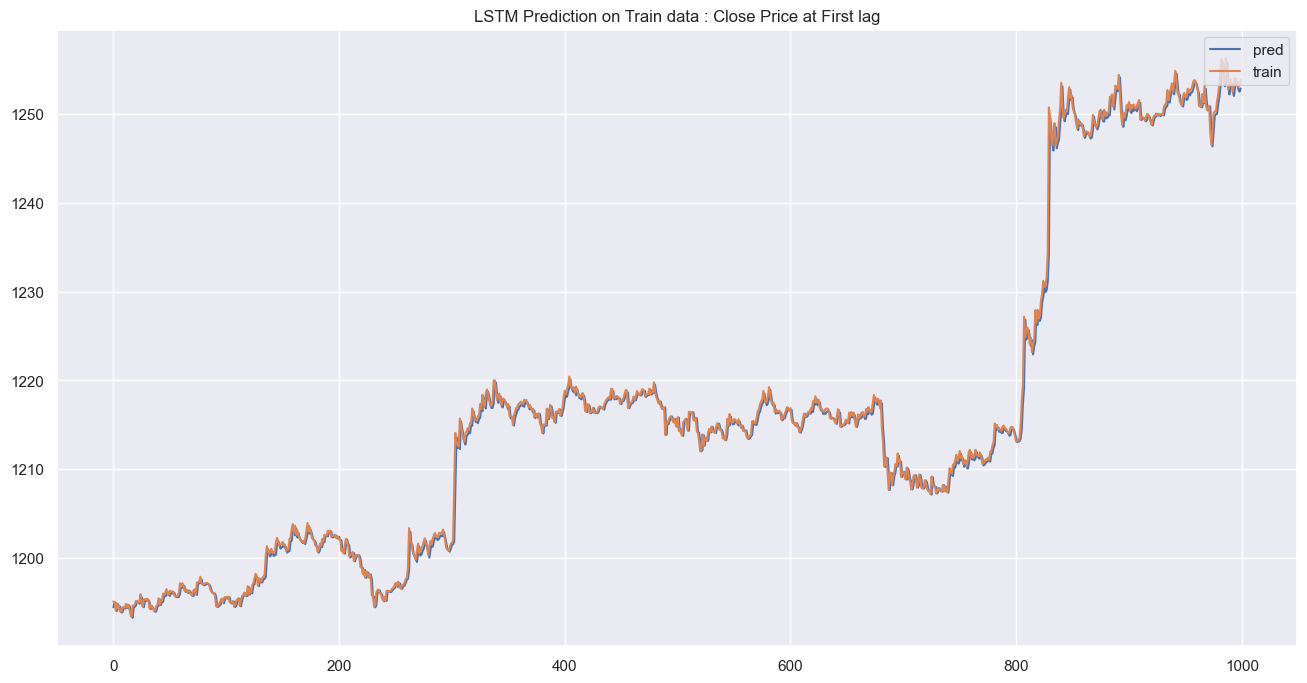

In [99]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at First lag")
plt.plot(y_train_pred_raw_1[:1000,0], label="pred")
plt.plot(y_train_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

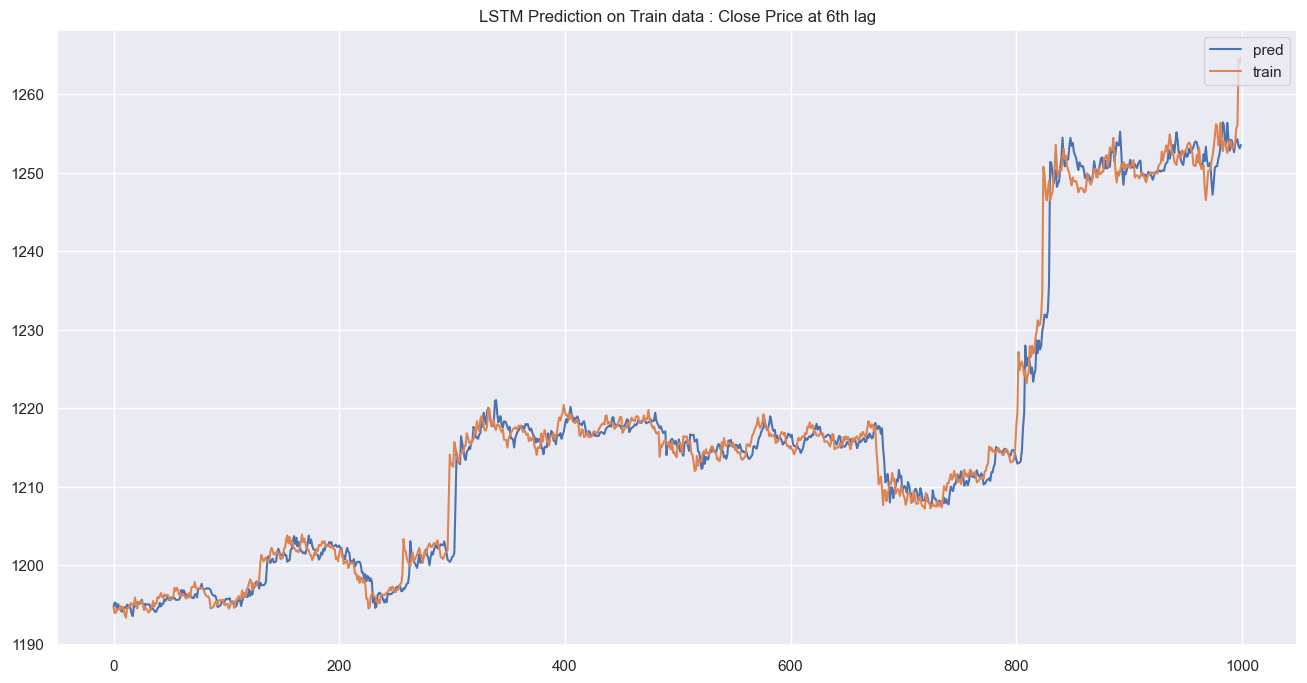

In [100]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at 6th lag")
plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
plt.plot(y_train_raw[:1000, 5], label="train")
plt.legend(loc='upper right')

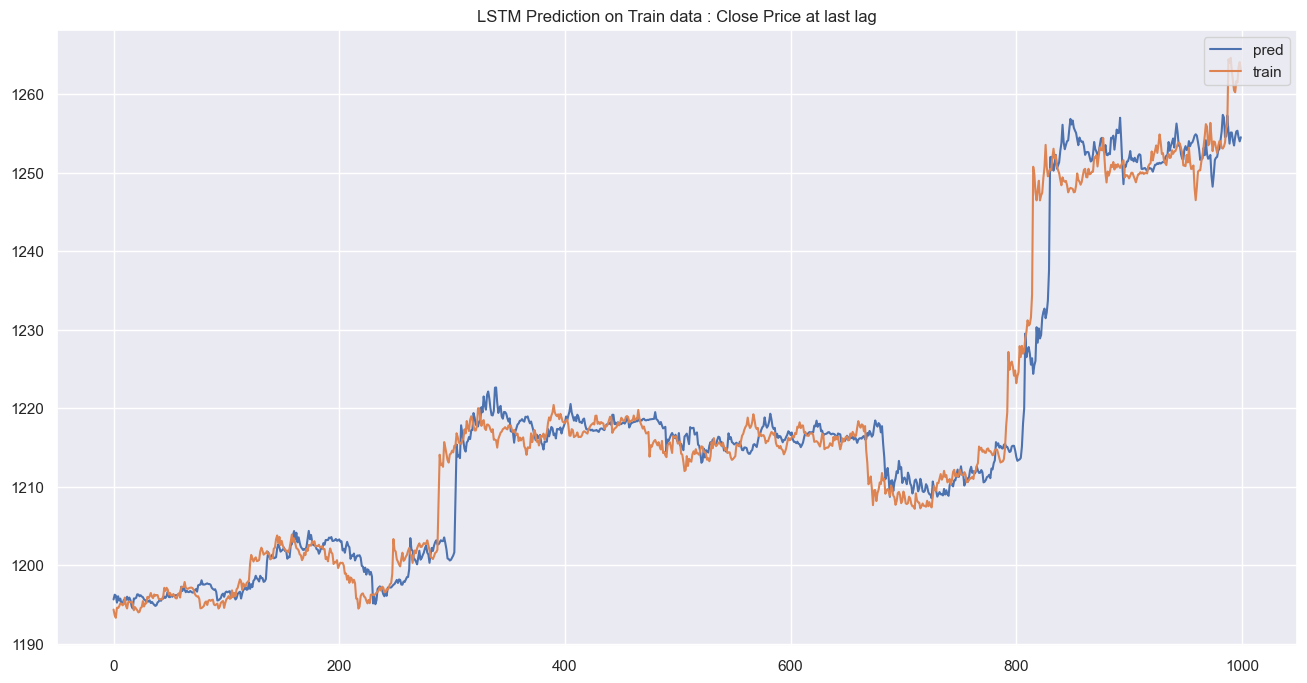

In [101]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Train data : Close Price at last lag")
plt.plot(y_train_pred_raw_1[:1000, -1], label="pred")
plt.plot(y_train_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

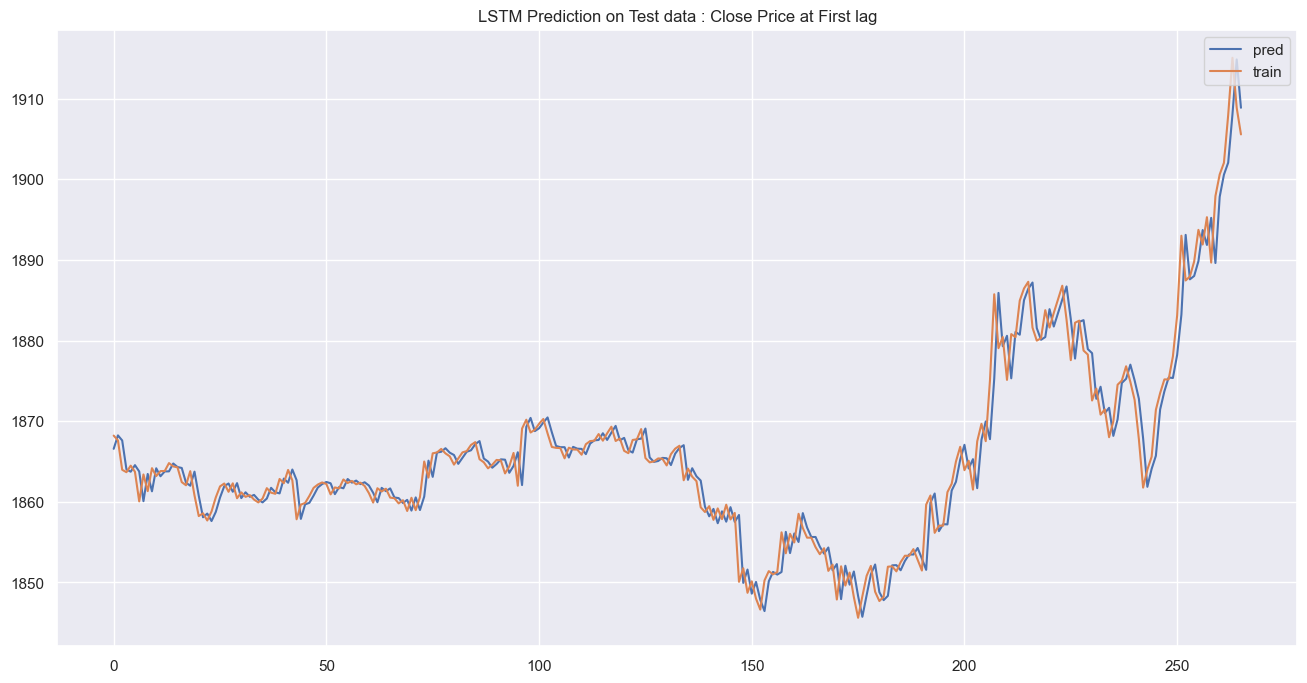

In [102]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw_1[:1000,0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

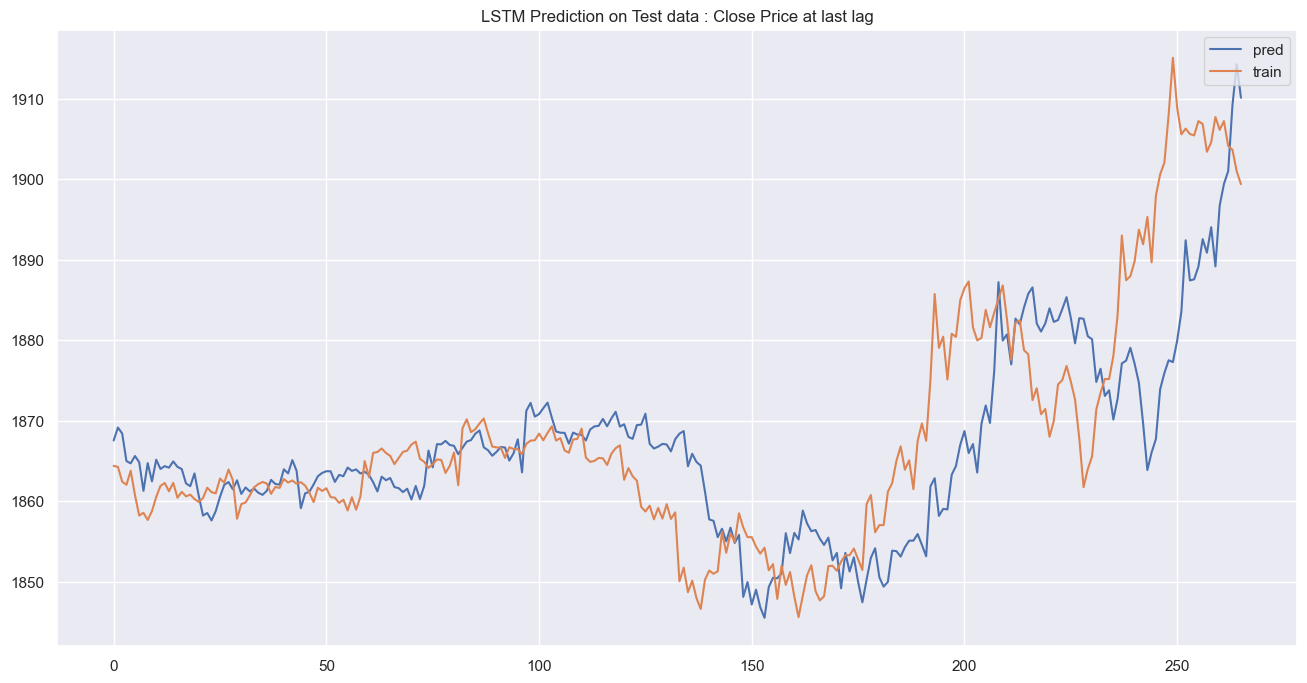

In [103]:
fig = plt.figure(figsize=(16, 8))
plt.title("LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw_1[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

In [94]:
y_train_pred_unscaled_1[0,:]

array([1.0000145 , 1.000004  , 0.9997744 , 0.9998144 , 0.99970543,
       0.99977815, 0.9998402 , 0.99998826, 1.0000583 , 0.99989843,
       0.9998479 , 0.99980295, 1.0000012 , 1.0000309 , 1.0000308 ],
      dtype=float32)

In [95]:
y_train_pred_unscaled_1[0,:] * X_train_raw[0,-1, 0]

array([1194.5574, 1194.5449, 1194.2705, 1194.3184, 1194.1881, 1194.275 ,
       1194.3491, 1194.526 , 1194.6096, 1194.4187, 1194.3583, 1194.3047,
       1194.5415, 1194.5769, 1194.5768], dtype=float32)

In [96]:
y_train_pred_raw_1[0,:]

array([1194.55737283, 1194.54484161, 1194.2705075 , 1194.31828279,
       1194.18812895, 1194.27499311, 1194.34911245, 1194.52597357,
       1194.60963373, 1194.41867497, 1194.35829726, 1194.30461236,
       1194.541424  , 1194.57688167, 1194.57673927])

### Autoencoder + LSTM reduced features

In [273]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

In [274]:
X_train[:,:,0:4].shape

(44961, 72, 4)

In [275]:
list_col_select[0:4]

['Close_ETH', 'Open_ETH', 'High_ETH', 'Low_ETH']

Concatenate 

In [276]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

1406/1406 [==============================] - 18s 13ms/step


(44961, 72, 16)

In [277]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

12/12 [==============================] - 0s 23ms/step


(367, 72, 16)

In [278]:
# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)

In [279]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((44961, 72, 20), (367, 72, 20))

Train

In [280]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 5
patience = 5
dropout_rate = 0.25
n_units = 140
tf.keras.backend.clear_session()
tf.random.set_seed(0)
# optimizer def 
#optim = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
#                      nesterov=nesterov)
optim = tf.optimizers.Adam()
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                verbose=1, patience=patience,
                                restore_best_weights=True)
# create model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(
    n_units,
    return_sequences=False,
    input_shape=X_train_.shape[-2:],
    )
)
multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
#multi_step_model.add(tf.keras.layers.BatchNormalization())
multi_step_model.add(tf.keras.layers.LayerNormalization())
multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
# compile
multi_step_model.compile(optimizer=optim, loss='mse')
# fitting
'''multi_step_history = multi_step_model.fit(X_train_sca, 
                                        epochs=EPOCHS,
                                        steps_per_epoch=EVALUATION_INTERVAL,
                                        validation_data=val_data_multi,
                                        validation_steps=1,
                                        callbacks=[es],
                                        verbose=0)'''

multi_step_history = multi_step_model.fit(
    X_train_, y_train_sca, epochs=EPOCHS,
    batch_size=BATCH_SIZE, 
    validation_data=(X_test_, y_test_sca), 
    verbose=1, 
    callbacks=[es]
)
# eval
mse_curr = np.min(multi_step_history.history['val_loss'])
mse_curr

Epoch 1/5
1406/1406 [==============================] - 44s 30ms/step - loss: 1.0700 - val_loss: 0.7014
Epoch 2/5
1406/1406 [==============================] - 40s 29ms/step - loss: 1.0027 - val_loss: 0.7520
Epoch 3/5
1406/1406 [==============================] - 40s 28ms/step - loss: 0.9894 - val_loss: 0.7590
Epoch 4/5
1406/1406 [==============================] - 42s 30ms/step - loss: 0.9690 - val_loss: 0.8309
Epoch 5/5
1406/1406 [==============================] - 40s 29ms/step - loss: 0.9691 - val_loss: 0.7449


0.7014010548591614

### Results

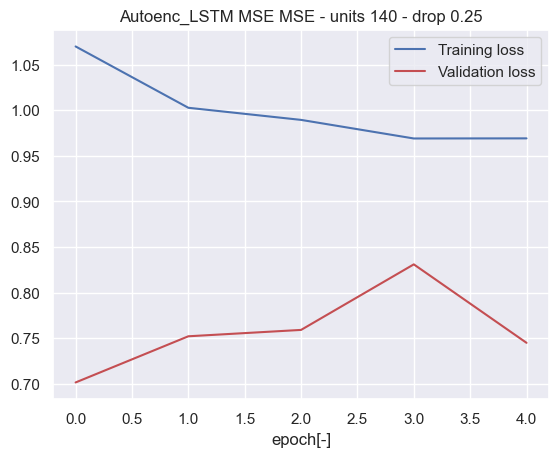

In [296]:
plot_train_history(
    multi_step_history,
    f"Autoenc_LSTM MSE MSE - units {n_units} - drop {dropout_rate}",
    saveFolder="data",
)

Save mdl

In [301]:
multi_step_model.save(path_mdl_predict_autoenc_lstm)

INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


INFO:tensorflow:Assets written to: data/mdl_predict_autoenc_lstm/assets


Predict

In [298]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

12/12 [==============================] - 0s 21ms/step


Plots

In [299]:
y_train_pred_raw[0:-1:FUTURE_TARGET,:].shape

(2998, 15)

In [300]:
y_train_pred_raw[0:-1:FUTURE_TARGET,:].ravel().shape

(44970,)

In [164]:
np.array(range(y_train_raw.shape[0])).shape

(44940,)

In [165]:
df_feat["Close_ETH"]

0        1196.32
1        1195.38
2        1194.55
3        1195.98
4        1196.06
          ...   
45476    1836.16
45477    1837.79
45478    1826.99
45479    1822.64
45480    1828.28
Name: Close_ETH, Length: 45481, dtype: float64

In [166]:
y_test_raw

array([[1826.02, 1833.11, 1831.72, ..., 1836.28, 1836.76, 1836.99],
       [1833.11, 1831.72, 1836.5 , ..., 1836.76, 1836.99, 1838.  ],
       [1831.72, 1836.5 , 1834.53, ..., 1836.99, 1838.  , 1839.84],
       ...,
       [1842.38, 1841.12, 1841.41, ..., 1836.51, 1836.16, 1837.79],
       [1841.12, 1841.41, 1842.23, ..., 1836.16, 1837.79, 1826.99],
       [1841.41, 1842.23, 1841.58, ..., 1837.79, 1826.99, 1822.64]])

In [167]:
y_train_raw[0::FUTURE_TARGET,:].ravel()[-100:]

array([1809.76, 1808.26, 1807.15, 1807.17, 1807.8 , 1807.69, 1809.12,
       1811.13, 1813.41, 1815.55, 1813.06, 1813.44, 1814.54, 1812.5 ,
       1809.58, 1810.5 , 1811.03, 1810.4 , 1810.79, 1811.47, 1811.62,
       1810.08, 1811.69, 1811.06, 1811.89, 1810.76, 1809.15, 1810.91,
       1810.31, 1808.1 , 1807.33, 1807.96, 1807.72, 1806.53, 1805.27,
       1805.8 , 1806.86, 1805.76, 1805.25, 1805.32, 1804.77, 1808.57,
       1807.04, 1807.15, 1811.99, 1811.  , 1811.6 , 1813.28, 1813.19,
       1813.28, 1813.54, 1813.55, 1812.26, 1812.2 , 1812.58, 1812.52,
       1812.56, 1813.34, 1811.27, 1811.37, 1811.92, 1810.85, 1811.63,
       1811.8 , 1811.18, 1811.94, 1811.49, 1812.2 , 1813.05, 1813.41,
       1813.86, 1813.33, 1813.78, 1814.32, 1817.46, 1818.26, 1819.02,
       1817.61, 1817.25, 1817.21, 1816.42, 1816.39, 1815.9 , 1816.02,
       1816.81, 1816.23, 1814.84, 1816.08, 1814.49, 1814.96, 1815.69,
       1815.73, 1816.16, 1814.95, 1814.57, 1813.58, 1813.29, 1814.48,
       1813.43, 1813

In [168]:
y_train_raw[0::FUTURE_TARGET,:].ravel()

array([1195.09, 1195.  , 1194.09, ..., 1814.48, 1813.43, 1813.22])

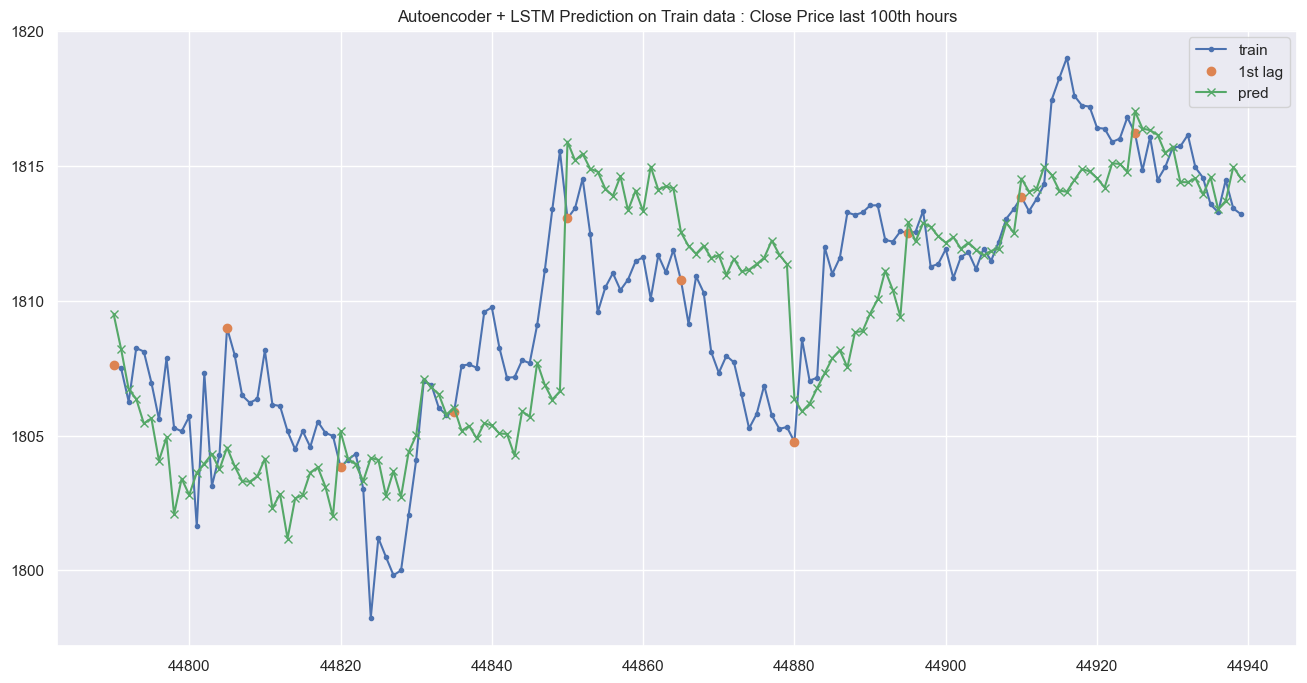

In [169]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder + LSTM Prediction on Train data : Close Price last 100th hours")
nb_pred = 10
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.array(range(0, y_train_raw.shape[0], FUTURE_TARGET))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]

plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'o', label ='1st lag')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")

plt.legend(loc='upper right')

In [170]:
y_test_raw.shape

(367, 15)

In [171]:
y_test_raw.shape[0]

367

In [172]:
y_test_raw[0::FUTURE_TARGET,:].ravel().shape

(375,)

In [173]:
np.array(range(0, y_test_raw.shape[0], FUTURE_TARGET)).shape

(25,)

In [174]:
y_test.shape

(367, 15)

In [175]:
y_test_raw.shape

(367, 15)

In [176]:
x_axis_1

array([    0,    15,    30, ..., 44895, 44910, 44925])

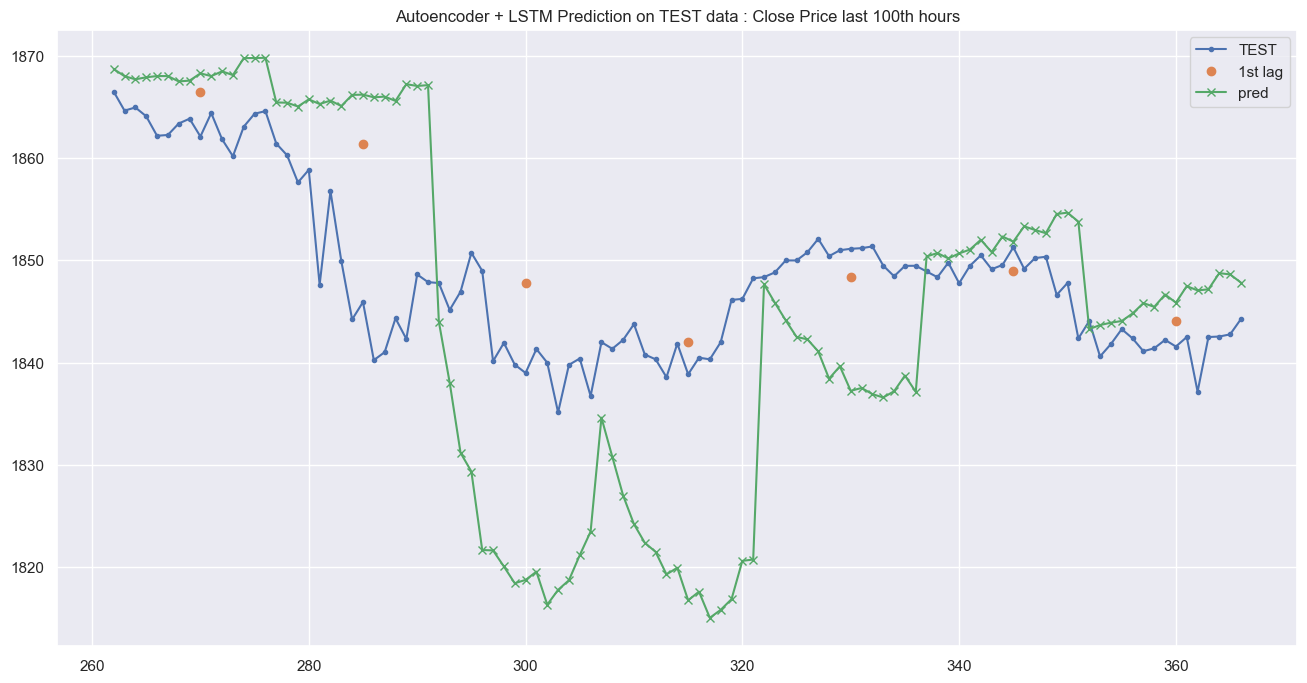

In [177]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder + LSTM Prediction on TEST data : Close Price last 100th hours")
nb_pred = 7
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.array(range(0, y_test_raw.shape[0], FUTURE_TARGET))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]

plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="TEST")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'o', label ='1st lag')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")

plt.legend(loc='upper right')

In [178]:
np.array(range(0,y_test_raw.shape[0], FUTURE_TARGET))

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180,
       195, 210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360])

In [179]:
y_test_raw[range(0,y_test_raw.shape[0], FUTURE_TARGET),:]

array([[1826.02, 1833.11, 1831.72, 1836.5 , 1834.53, 1835.42, 1833.77,
        1836.26, 1838.49, 1838.75, 1841.12, 1838.2 , 1836.28, 1836.76,
        1836.99],
       [1838.  , 1839.84, 1841.12, 1842.13, 1840.16, 1842.22, 1848.2 ,
        1846.55, 1845.46, 1844.  , 1847.21, 1845.48, 1844.46, 1844.73,
        1847.74],
       [1847.01, 1855.73, 1863.66, 1860.38, 1859.41, 1865.73, 1864.87,
        1861.95, 1884.27, 1876.86, 1880.02, 1877.13, 1874.8 , 1874.83,
        1875.11],
       [1874.72, 1874.93, 1875.76, 1875.84, 1876.33, 1876.8 , 1873.94,
        1874.77, 1874.59, 1874.31, 1873.29, 1874.75, 1874.87, 1873.95,
        1874.57],
       [1873.5 , 1880.12, 1881.28, 1879.31, 1880.36, 1880.74, 1882.25,
        1895.9 , 1891.82, 1890.59, 1889.69, 1888.71, 1883.59, 1879.64,
        1881.59],
       [1879.38, 1878.81, 1874.59, 1877.21, 1877.44, 1876.58, 1879.32,
        1877.88, 1880.55, 1879.54, 1878.45, 1877.5 , 1875.8 , 1876.36,
        1879.1 ],
       [1878.76, 1880.99, 1879.67, 1878.

In [180]:
y_test_raw[:,0]

array([1826.02, 1833.11, 1831.72, 1836.5 , 1834.53, 1835.42, 1833.77,
       1836.26, 1838.49, 1838.75, 1841.12, 1838.2 , 1836.28, 1836.76,
       1836.99, 1838.  , 1839.84, 1841.12, 1842.13, 1840.16, 1842.22,
       1848.2 , 1846.55, 1845.46, 1844.  , 1847.21, 1845.48, 1844.46,
       1844.73, 1847.74, 1847.01, 1855.73, 1863.66, 1860.38, 1859.41,
       1865.73, 1864.87, 1861.95, 1884.27, 1876.86, 1880.02, 1877.13,
       1874.8 , 1874.83, 1875.11, 1874.72, 1874.93, 1875.76, 1875.84,
       1876.33, 1876.8 , 1873.94, 1874.77, 1874.59, 1874.31, 1873.29,
       1874.75, 1874.87, 1873.95, 1874.57, 1873.5 , 1880.12, 1881.28,
       1879.31, 1880.36, 1880.74, 1882.25, 1895.9 , 1891.82, 1890.59,
       1889.69, 1888.71, 1883.59, 1879.64, 1881.59, 1879.38, 1878.81,
       1874.59, 1877.21, 1877.44, 1876.58, 1879.32, 1877.88, 1880.55,
       1879.54, 1878.45, 1877.5 , 1875.8 , 1876.36, 1879.1 , 1878.76,
       1880.99, 1879.67, 1878.99, 1878.8 , 1879.83, 1878.01, 1878.77,
       1878.52, 1880

In [264]:
y_test_raw[0::FUTURE_TARGET,:].ravel()

array([1760.35, 1764.12, 1776.08, 1773.88, 1778.87, 1763.31, 1765.53,
       1765.  , 1764.63, 1750.3 , 1753.44, 1752.2 , 1756.2 , 1763.38,
       1764.96, 1765.42, 1756.1 , 1754.93, 1719.75, 1711.74, 1717.42,
       1707.92, 1714.52, 1704.58, 1707.74, 1713.01, 1709.49, 1715.22,
       1707.56, 1717.02, 1713.72, 1711.65, 1718.16, 1724.3 , 1731.44,
       1724.53, 1728.07, 1718.7 , 1717.58, 1745.48, 1737.05, 1737.6 ,
       1740.03, 1744.08, 1735.31, 1736.42, 1777.23, 1785.85, 1774.54,
       1769.05, 1770.48, 1772.99, 1775.24, 1778.47, 1779.42, 1778.07,
       1791.85, 1789.67, 1805.06, 1804.86, 1820.63, 1814.24, 1810.97,
       1811.22, 1810.83, 1810.18, 1796.64, 1807.68, 1793.24, 1798.5 ,
       1803.81, 1809.02, 1803.47, 1794.61, 1790.52, 1793.07, 1785.26,
       1791.09, 1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47,
       1799.12, 1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01])

In [253]:
y_test_raw[0::FUTURE_TARGET,:]

array([[1760.35, 1764.12, 1776.08, 1773.88, 1778.87, 1763.31, 1765.53,
        1765.  , 1764.63, 1750.3 , 1753.44, 1752.2 , 1756.2 ],
       [1763.38, 1764.96, 1765.42, 1756.1 , 1754.93, 1719.75, 1711.74,
        1717.42, 1707.92, 1714.52, 1704.58, 1707.74, 1713.01],
       [1709.49, 1715.22, 1707.56, 1717.02, 1713.72, 1711.65, 1718.16,
        1724.3 , 1731.44, 1724.53, 1728.07, 1718.7 , 1717.58],
       [1745.48, 1737.05, 1737.6 , 1740.03, 1744.08, 1735.31, 1736.42,
        1777.23, 1785.85, 1774.54, 1769.05, 1770.48, 1772.99],
       [1775.24, 1778.47, 1779.42, 1778.07, 1791.85, 1789.67, 1805.06,
        1804.86, 1820.63, 1814.24, 1810.97, 1811.22, 1810.83],
       [1810.18, 1796.64, 1807.68, 1793.24, 1798.5 , 1803.81, 1809.02,
        1803.47, 1794.61, 1790.52, 1793.07, 1785.26, 1791.09],
       [1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47, 1799.12,
        1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01]])

In [251]:
y_test_raw[-13:, :]

array([[1816.8 , 1787.66, 1796.82, 1797.13, 1796.16, 1806.47, 1799.12,
        1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01],
       [1787.66, 1796.82, 1797.13, 1796.16, 1806.47, 1799.12, 1800.63,
        1803.53, 1804.62, 1804.21, 1797.69, 1795.01, 1789.42],
       [1796.82, 1797.13, 1796.16, 1806.47, 1799.12, 1800.63, 1803.53,
        1804.62, 1804.21, 1797.69, 1795.01, 1789.42, 1785.56],
       [1797.13, 1796.16, 1806.47, 1799.12, 1800.63, 1803.53, 1804.62,
        1804.21, 1797.69, 1795.01, 1789.42, 1785.56, 1770.18],
       [1796.16, 1806.47, 1799.12, 1800.63, 1803.53, 1804.62, 1804.21,
        1797.69, 1795.01, 1789.42, 1785.56, 1770.18, 1776.6 ],
       [1806.47, 1799.12, 1800.63, 1803.53, 1804.62, 1804.21, 1797.69,
        1795.01, 1789.42, 1785.56, 1770.18, 1776.6 , 1781.62],
       [1799.12, 1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01,
        1789.42, 1785.56, 1770.18, 1776.6 , 1781.62, 1795.23],
       [1800.63, 1803.53, 1804.62, 1804.21, 1797.69, 1795.01, 

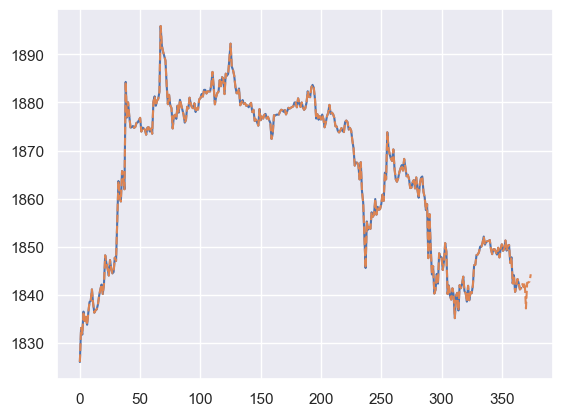

In [181]:
plt.plot(y_test_raw[:,0])
plt.plot(y_test_raw[0::FUTURE_TARGET,:].ravel(),'--')

In [182]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1842.38 1841.12 1841.41 1842.23 1841.58 1842.51 1837.16 1842.51 1842.56
 1842.77 1844.27 1841.51 1836.51 1836.16 1837.79]
[1844.26287957 1844.87704197 1845.73686933 1845.96737249 1846.58922565
 1847.64857339 1847.67933644 1848.54421773 1847.79799394 1849.397453
 1849.36910705 1849.38976224 1850.21816733 1850.17553853 1848.90458493]


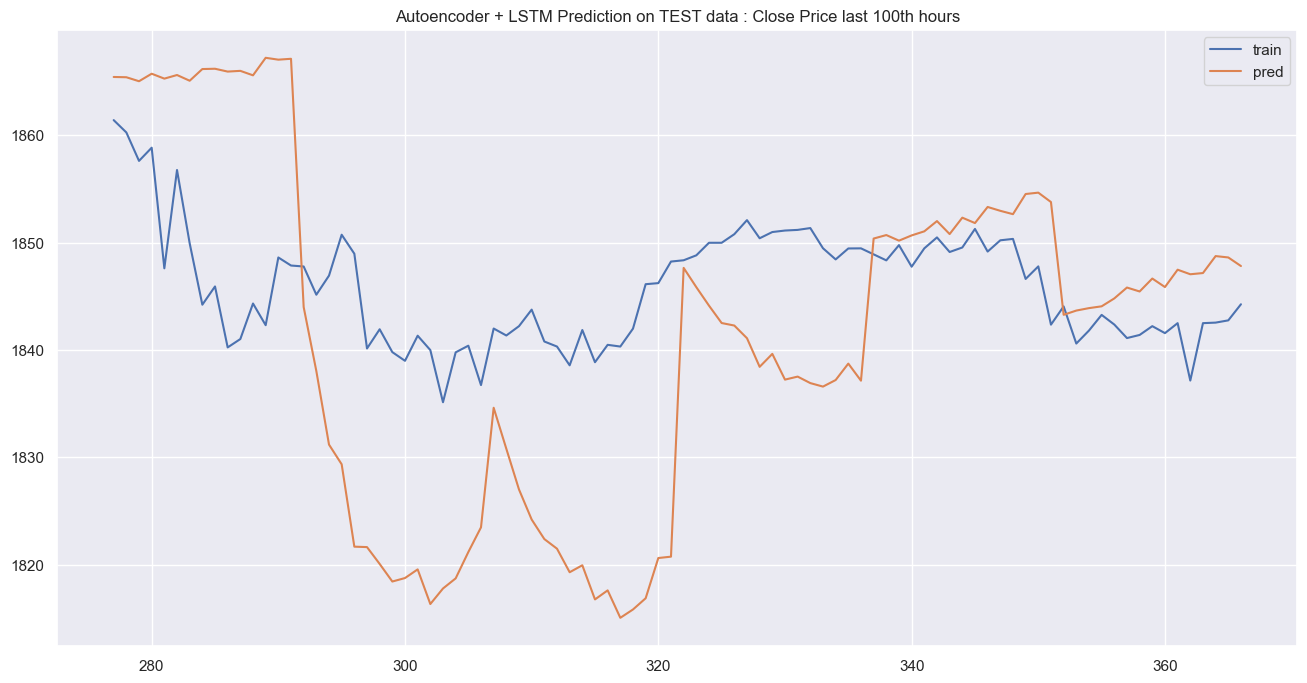

In [183]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder + LSTM Prediction on TEST data : Close Price last 100th hours")
x_axis = np.array(range(y_test_raw.shape[0]))
plt.plot(x_axis[-90:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-90:], label="train")
plt.plot(x_axis[-90:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-90:], label="pred")
plt.legend(loc='upper right')

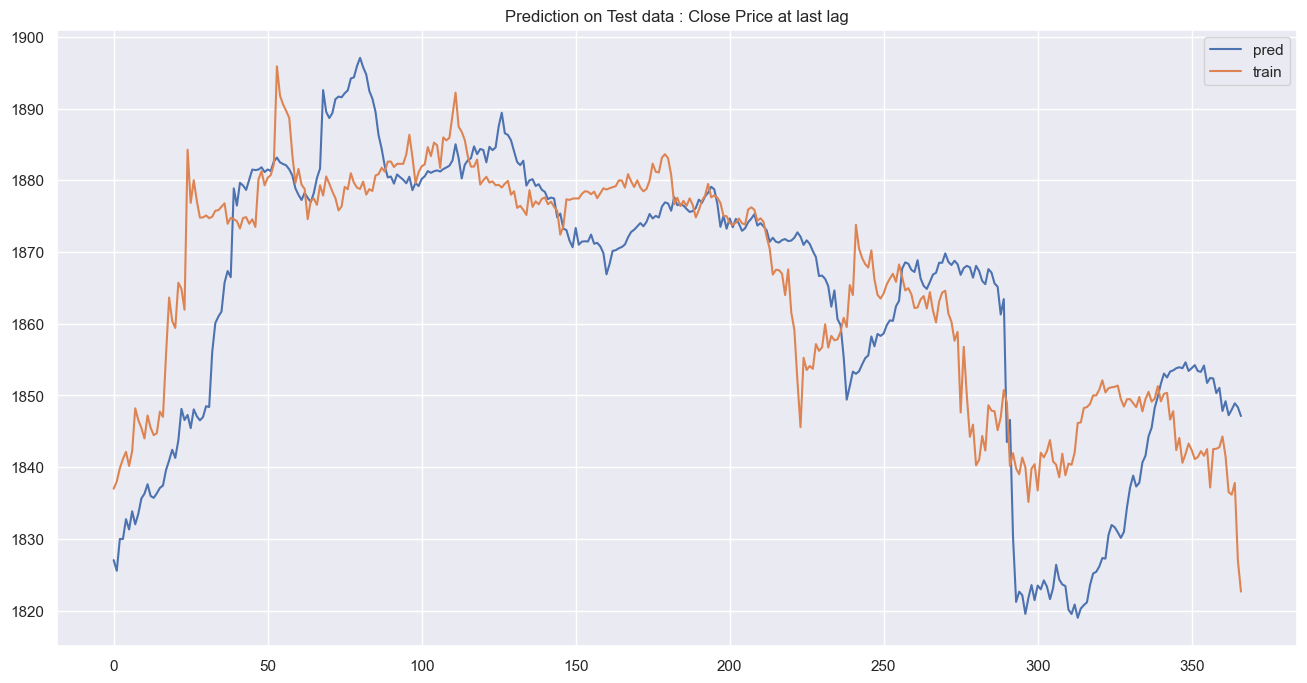

In [184]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

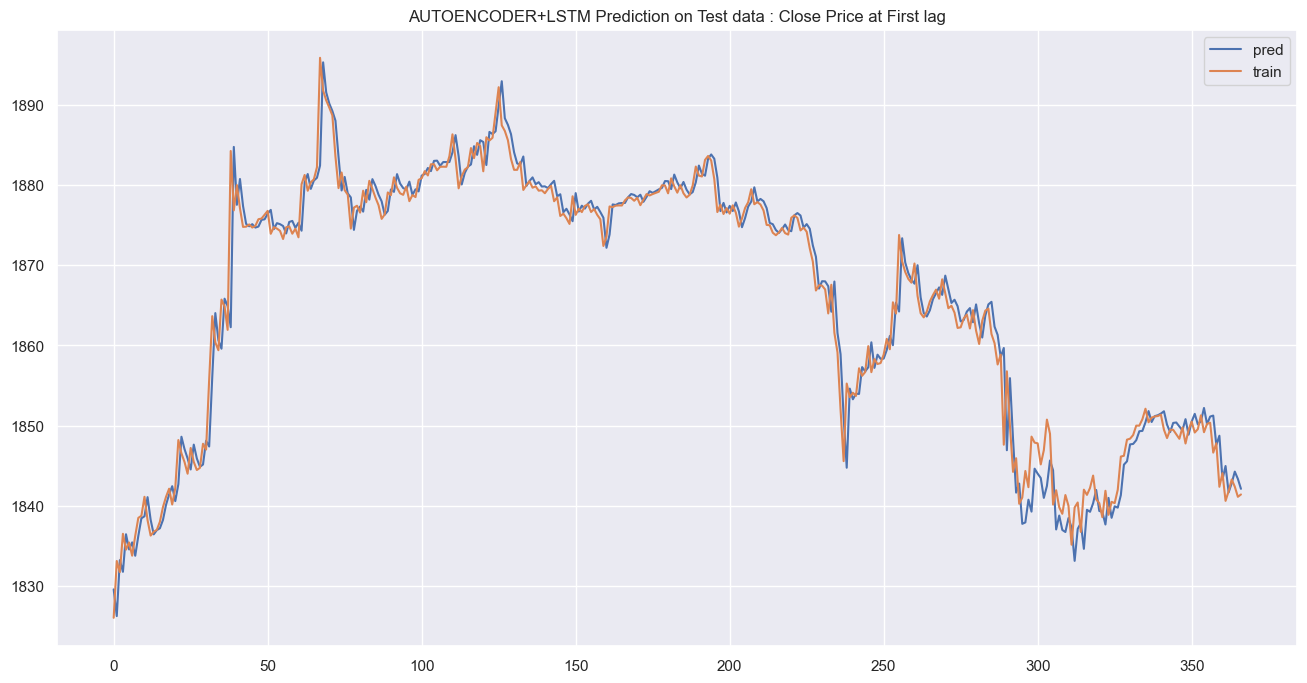

In [185]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

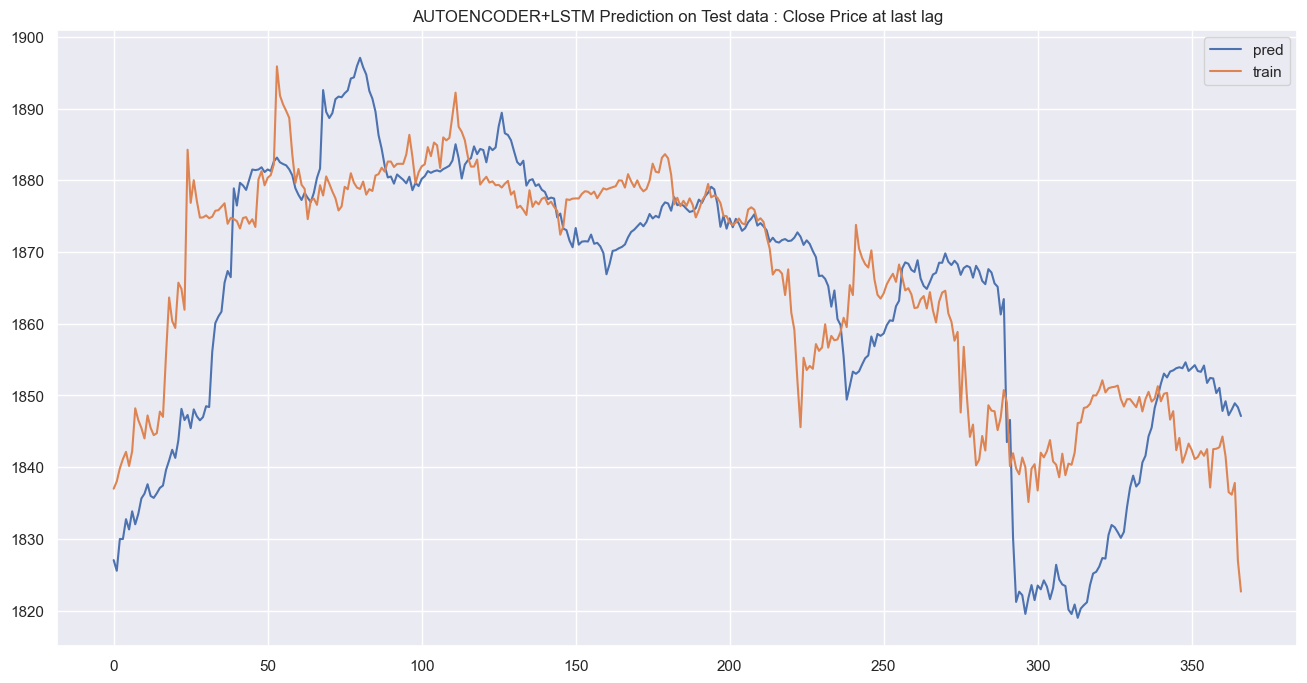

In [186]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

In [125]:
str(time.time())

'1680725792.947519'

## Predict last prediction

In [281]:
X_test_sca.shape

(367, 72, 104)

In [282]:
df_feat["Close_ETH"].iloc[-1]

1832.77

In [283]:
df_feat["Close_ETH"].iloc[-1]

1832.77

In [284]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale py ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate
X_last_ = np.concatenate([X_last_sca[:,:,0:4], X_last_encoded_sca], axis=-1)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))

[batch, lags, features]
X_last[0,:,0]:
[1848.83 1850.   1850.   1850.8  1852.11 1850.42 1851.   1851.14 1851.2
 1851.37 1849.49 1848.45 1849.47 1849.48 1848.92 1848.36 1849.78 1847.77
 1849.48 1850.5  1849.14 1849.56 1851.29 1849.18 1850.23 1850.36 1846.63
 1847.8  1842.37 1844.07 1840.61 1841.82 1843.28 1842.38 1841.12 1841.41
 1842.23 1841.58 1842.51 1837.16 1842.51 1842.56 1842.77 1844.27 1841.51
 1836.51 1836.16 1837.79 1826.99 1822.64 1826.2  1829.21 1832.05 1832.81
 1829.78 1827.84 1829.23 1828.59 1828.43 1830.26 1830.27 1829.72 1831.39
 1829.71 1827.1  1829.78 1830.63 1830.41 1833.   1831.74 1832.33 1832.77]
X_last[0,:,0] after divide by price:
[1.00876269 1.00940107 1.00940107 1.00983757 1.01055233 1.00963023
 1.00994669 1.01002308 1.01005582 1.01014857 1.0091228  1.00855536
 1.00911189 1.00911735 1.0088118  1.00850625 1.00928103 1.00818433
 1.00911735 1.00967388 1.00893184 1.009161   1.01010492 1.00895366
 1.00952656 1.00959749 1.00756232 1.0082007  1.00523797 1.00616553
 1.00

In [285]:
PAST_HISTORY

72

In [286]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,train
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,1710.244864,1709.520092,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,1710.244864,1709.520092,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,1710.244864,1709.520092,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,1710.244864,1709.520092,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,1710.244864,1709.520092,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,1686180300000,1830.63,1830.83,1829.89,1830.41,406.3064,2023-06-07 23:25:00,1839.040000,1841.440000,1832.730,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
45498,1686180600000,1830.41,1833.00,1830.25,1833.00,500.6436,2023-06-07 23:30:00,1839.092500,1841.440000,1832.730,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
45499,1686180900000,1833.00,1833.00,1831.00,1831.74,625.5965,2023-06-07 23:35:00,1839.202500,1841.440000,1832.730,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False
45500,1686181200000,1831.75,1832.33,1830.86,1832.33,367.2071,2023-06-07 23:40:00,1839.202500,1841.440000,1831.345,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,False


In [287]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [288]:
y_last_pred_unscaled

array([[1.0002449 , 1.0002517 , 1.0007257 , 1.0007071 , 1.0007714 ,
        1.0013181 , 1.0008879 , 1.0009604 , 1.0006955 , 1.0007404 ,
        1.0003047 , 1.000313  , 0.99988055, 1.0000594 , 1.0008612 ]],
      dtype=float32)

In [289]:
df_feat["Close_ETH"].iloc[-1]

1832.77

In [290]:
y_last_pred_raw

array([[1833.2188, 1833.2312, 1834.1001, 1834.066 , 1834.1838, 1835.1858,
        1834.3973, 1834.5302, 1834.0447, 1834.1271, 1833.3285, 1833.3438,
        1832.5511, 1832.8788, 1834.3484]], dtype=float32)

In [291]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [292]:
list_pred

[1834.066,
 1834.1838,
 1835.1858,
 1834.3973,
 1834.5302,
 1834.0447,
 1834.1271,
 1833.3285,
 1833.3438,
 1832.5511,
 1832.8788,
 1834.3484]

In [293]:
save_list(list_pred, path_save_pred_vals)

In [294]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [295]:
list_pred_reload

[1834.066,
 1834.1838,
 1835.1858,
 1834.3973,
 1834.5302,
 1834.0447,
 1834.1271,
 1833.3285,
 1833.3438,
 1832.5511,
 1832.8788,
 1834.3484]